In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from matplotlib.pyplot import figure

# set global figure size
plt.rcParams["figure.figsize"] = (10,6)

from ipynb.fs.full.common import *

In [2]:
# load gameplays
gameplays = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\gameplays.json").readlines()).apply(json.loads))

In [14]:
gameplays.columns

Index(['UUID', 'events', 'logs', 'obstacles', 'nr_jumps', 'playIntro',
       'newHighScore', 'distanceRan', 'actualDistance', 'invertedGameOver',
       'obstacleTypes', 'gameOverTime', 'gameOverScreen', 'dateTime', 'USERID',
       '_id.$oid', 'collisionObstacle.typeConfig.type',
       'collisionObstacle.typeConfig.width',
       'collisionObstacle.typeConfig.height',
       'collisionObstacle.typeConfig.yPos',
       'collisionObstacle.typeConfig.multipleSpeed',
       'collisionObstacle.typeConfig.minGap',
       'collisionObstacle.typeConfig.minSpeed',
       'collisionObstacle.typeConfig.collisionBoxes',
       'collisionObstacle.dimensions.WIDTH',
       'collisionObstacle.dimensions.HEIGHT', 'collisionObstacle.size',
       'collisionObstacle.width', 'collisionObstacle.xPos',
       'collisionObstacle.yPos', 'collisionObstacle.collisionBoxes',
       'collisionObstacle.speedOffset', 'collisionObstacle.gap',
       'runnerConfig.ACCELERATION', 'runnerConfig.BG_CLOUD_SPEED',
   

In [3]:
# load questionresponses and expand the response columns to contain "lastentry" and "secondlastentry" instead of 'A', 'B' or 'BOTH'
questionresponses = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\questionresponses.json").readlines()).apply(json.loads))
questionresponses = expand_questionresponses(questionresponses)

---------------------------------------------------------------------------------------------------------------- GAMEPLAYS ----------------------------------------------------------------------------------------------------------------

In [4]:
gameplays = add_distance_per_jump(gameplays)

In [5]:
# top highest scores before preprocessing
# we see some high scores with unrealistic corresponding amount of jumps
gameplays[['actualDistance', 'nr_jumps', 'distance_per_jump']].nlargest(5, 'actualDistance')

,actualDistance,nr_jumps,distance_per_jump
782,20005,2,10002.500000
909,10598,529,20.034026
1050,10245,5,2049.000000
785,8182,782,10.462916
609,7954,582,13.666667


In [6]:
gameplays['distance_per_jump'].median()

14.857142857142858

In [7]:
import numpy as np
a = np.array(gameplays['distance_per_jump'])
p = np.percentile(a, 98) # return 50th percentile, e.g median
p

104.79999999999973

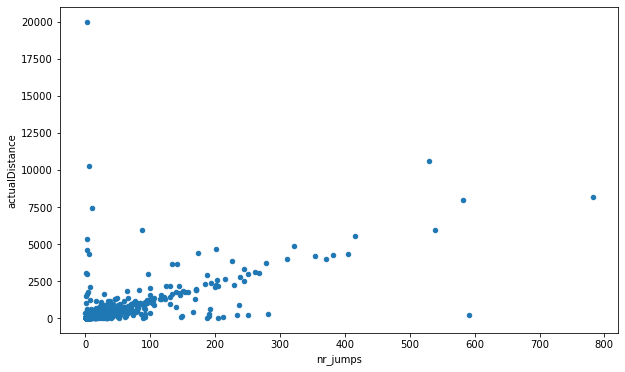

In [8]:
# actualDistance (score)  ~  nr_jumps 
# linear, a few outliers
gameplays.plot(x="nr_jumps", y="actualDistance", kind="scatter")

plt.savefig('graphs/notebook/scatter_jumps_score_no_preprocessing.png')

In [9]:
# preprocess gameplays
gameplays = preprocess_gameplays(gameplays)

In [10]:
# top highest scores after preprocessing
gameplays[['actualDistance', 'nr_jumps', 'distance_per_jump']].nlargest(5, 'actualDistance')

,actualDistance,nr_jumps,distance_per_jump
211,4850,321,15.109034
840,4667,201,23.218905
1007,4379,173,25.312139
900,4359,404,10.789604
875,4254,381,11.165354


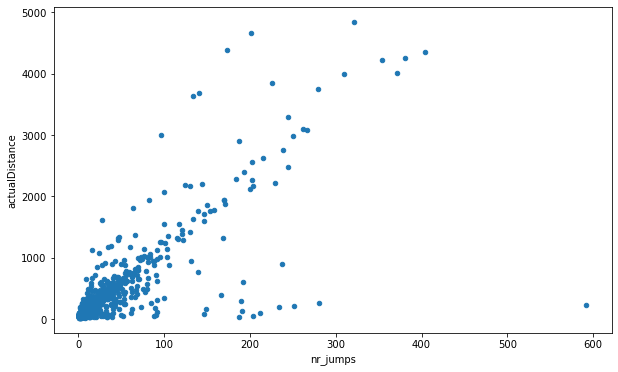

In [11]:
# actualDistance (score)  ~  nr_jumps 
# linear, a few outliers

gameplays.plot(x="nr_jumps", y="actualDistance", kind="scatter")
plt.savefig('graphs/notebook/scatter_jumps_score.png')

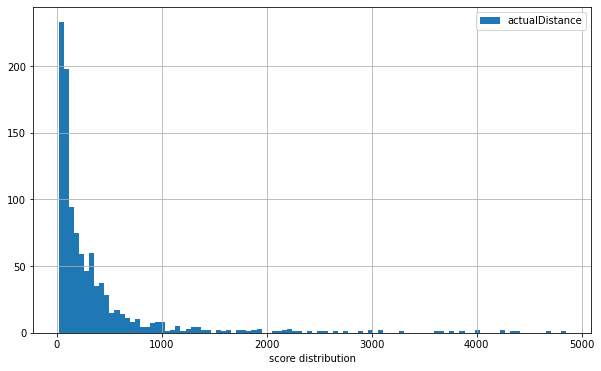

In [12]:
# Score distribution (after preprocessing gameplays)
ax = gameplays["actualDistance"].hist(bins=100, legend=True)
ax.set_xlabel("score distribution")
plt.savefig('graphs/notebook/score_distribution.png')

--------------------------------------------------------------------------------------------------------- QUESTIONRESPONSES ---------------------------------------------------------------------------------------------------------

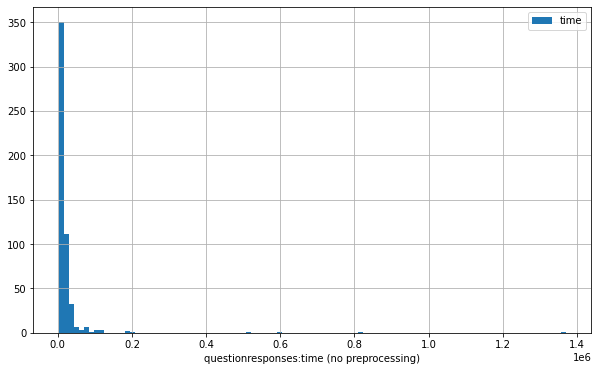

In [13]:
# time distribution to fill in form, before preprocessing
ax = questionresponses["time"].hist(bins=100, legend=True)
ax.set_xlabel("questionresponses:time (no preprocessing)")
plt.savefig('graphs/notebook/form_time_distribution_no_preprocessing.png')

In [14]:
top_times = questionresponses[["time"]].nlargest(5, 'time')
top_times['minutes'] = top_times['time'] / 60000
top_times

,time,minutes
387,1370129.625,22.835494
389,814790.505,13.579842
347,594588.980,9.909816
315,510120.665,8.502011
488,200455.380,3.340923


In [15]:
questionresponses["time"].median()

12207.299999980023

In [16]:
import numpy as np
a = np.array(questionresponses["time"])
p = np.percentile(a, 95) # return 50th percentile, e.g median
p

47742.400000020505

In [17]:
# preprocess questionresponses
questionresponses = preprocess_questionresponses(questionresponses)

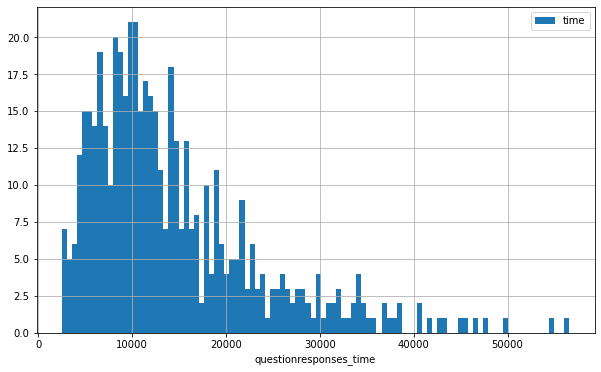

In [18]:
# time distribution to fill in form (after preprocessing questionresponses) 
ax = questionresponses["time"].hist(bins=100, legend=True)
ax.set_xlabel("questionresponses_time")
plt.savefig('graphs/notebook/form_time_distribution.png')

In [19]:
top_times = questionresponses[["time"]].nlargest(5, 'time')
top_times['minutes'] = top_times['time'] / 60000
top_times

,time,minutes
292,56565.195,0.942753
86,54661.430,0.911024
496,49774.060,0.829568
282,47862.000,0.797700
395,46666.000,0.777767


------------------------------------------------------------------------------------------------------------------ OTHER ------------------------------------------------------------------------------------------------------------------

In [20]:
def count_piechart(collection, column):
    counts = collection[column].groupby(collection[column]).count()
    labels = []
    for type_ in counts.index:
        percentage = "%.2f" % (counts[type_]/counts.sum()*100)
        labels.append(str(type_) + "\n" + str(percentage) + "%")
    labels

    p = plt.pie(counts, labels=labels)

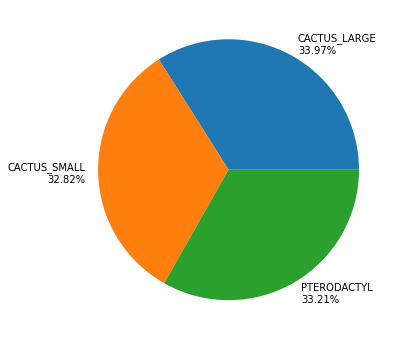

In [21]:
# What obstacle do players collide with upon dying?

count_piechart(gameplays, "collisionObstacle.typeConfig.type")
plt.savefig('graphs/notebook/collisionObstacle_pie.png')

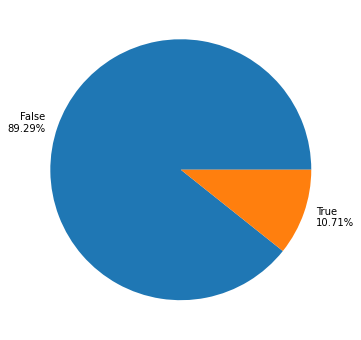

In [22]:
# Do players die during nightmode (when nightmode is enabled)? 

coll = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
count_piechart(coll, "invertedGameOver")

plt.savefig('graphs/notebook/invertedGameOver_pie.png')

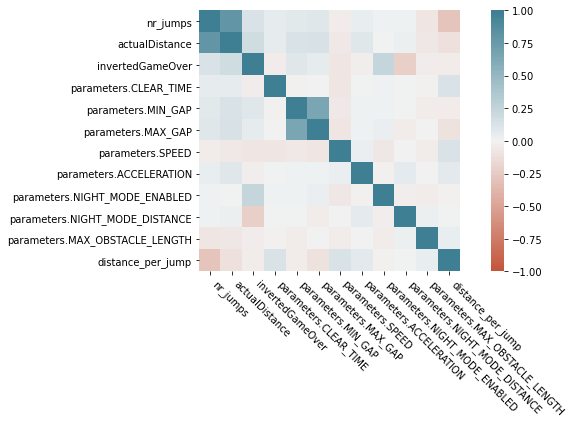

In [32]:
# Are there any correlations between these relevant columns?
# actualDistance (score)  ~  nr_jumps 
# night_mode enabled      ~  invertedGameOver

gameplays = add_distance_per_jump(gameplays)

corr = gameplays[["nr_jumps", "actualDistance", "invertedGameOver", "parameters.CLEAR_TIME", "parameters.MIN_GAP", 'parameters.MAX_GAP',  "parameters.SPEED", "parameters.ACCELERATION", 'parameters.NIGHT_MODE_ENABLED', 'parameters.NIGHT_MODE_DISTANCE','parameters.MAX_OBSTACLE_LENGTH',  "distance_per_jump" ]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=-45,
    horizontalalignment='left'
);
plt.tight_layout()
figure = ax.get_figure()  
figure.savefig('graphs/notebook/gameplays_heatmap.png')

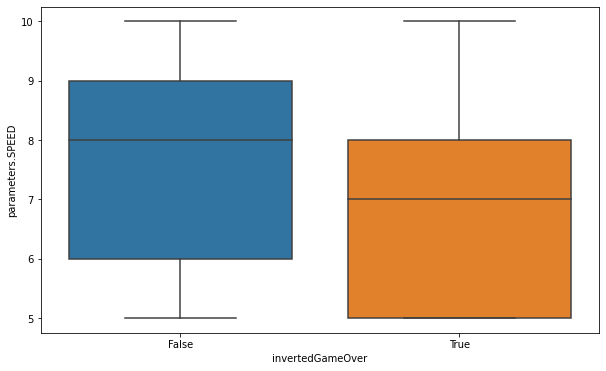

In [24]:
# Does speed have an effect on when players die during night mode?
# todo: filter out only games where night mode is enabled

coll = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
sns.boxplot(y=coll['parameters.SPEED'], x=coll['invertedGameOver'])

plt.savefig('graphs/notebook/boxplot_invertedGameOver_speed.png')

<AxesSubplot:ylabel='actualDistance'>

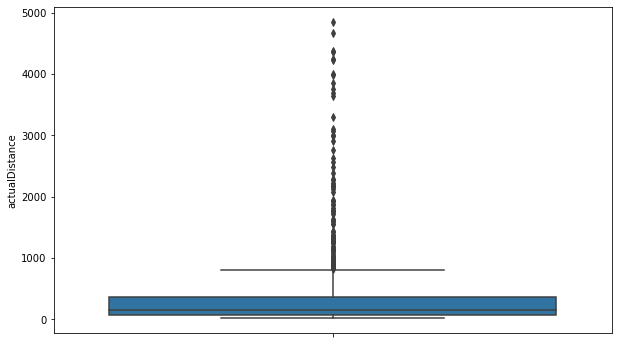

In [25]:
sns.boxplot(y=gameplays['actualDistance'])

<AxesSubplot:ylabel='actualDistance'>

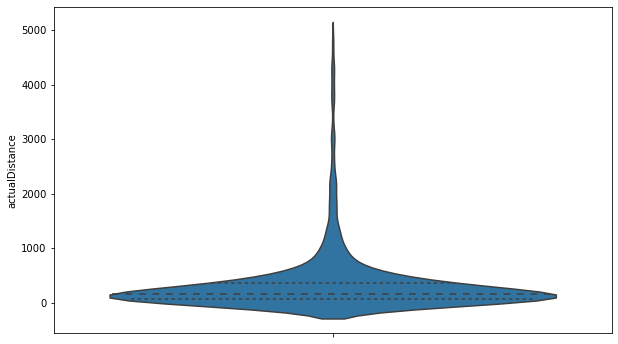

In [26]:
sns.violinplot(y=gameplays['actualDistance'],  inner="quartile")

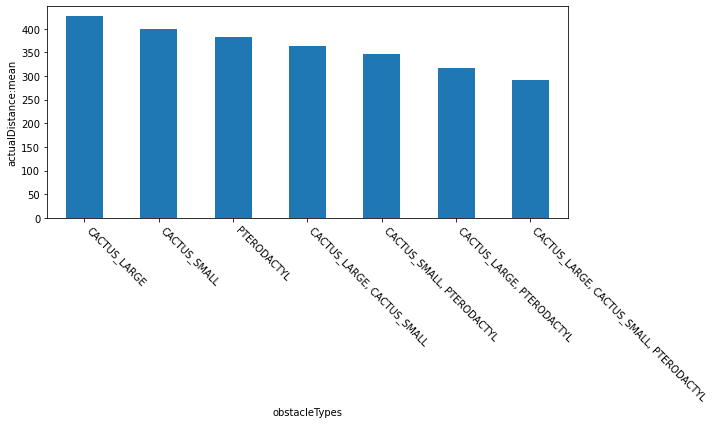

In [33]:
# mean score per obstacleTypes config
# -> get a feeling of difficulty per 'rank'

def normalize_obstacleType(entries):
    return ', '.join([obstacleType['type'] for obstacleType in entries])
normalized_obstacleTypes = gameplays["obstacleTypes"].apply(normalize_obstacleType)
#print(normalized_obstacleTypes)
group_means = gameplays["actualDistance"].groupby(normalized_obstacleTypes).mean().sort_values(ascending=False)
#print(group_means)

ax = group_means.plot(kind="bar")
# rotate x labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=-45,
    horizontalalignment='left'
);
ax.set_ylabel("actualDistance:mean")
ax
plt.tight_layout()
plt.savefig('graphs/notebook/bar_obstacleTypes_spec_mean_score.png')